In [185]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sktime.split import temporal_train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [186]:
csv_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'clean_data', 'main_df_clean.csv'))
df_original = pd.read_csv(csv_path)

df_original["Date"] = pd.to_datetime(df_original["Date"], errors="coerce", format="%m/%Y")
df_original["Date"] = pd.PeriodIndex(df_original["Date"], freq="M")
df_original = df_original.sort_values("Date").reset_index(drop=True)

df = df_original.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns

df[numeric_cols] = df[numeric_cols].diff()
df = df.iloc[1:].reset_index(drop=True)

df = df.dropna(axis='columns', how='all')

split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

imputer = IterativeImputer(random_state=42)
train_df[numeric_cols] = imputer.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = imputer.transform(test_df[numeric_cols])

train_last_date = train_df["Date"].iloc[-1]
last_train_price = df_original.loc[df_original["Date"] == train_last_date, "Coffee"].values[0]


In [187]:
def build_lagged_features(data, target_col, window_size):
    """builds a feature matrix by taking 'window_size' 
    lags of all numeric cols in 'data' to predict the 
    next step of 'target_col'."""
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    target_idx = list(numeric_cols).index(target_col)
    
    values = data[numeric_cols].values
    X, y = [], []
    for i in range(len(values) - window_size):
        past_window = values[i : i + window_size]  
        X.append(past_window.flatten())          
        y.append(values[i + window_size, target_idx])
    
    return np.array(X), np.array(y)

In [188]:
target_col = "Coffee"
window_size = 6
X_train, y_train = build_lagged_features(train_df, 'Coffee', window_size)
X_test, y_test = build_lagged_features(test_df, 'Coffee', window_size)

print(f"train shape: {X_train.shape}, {y_train.shape}")
print(f"test shape: {X_test.shape}, {y_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.01, 0.1, 1, 10, 100]
best_alpha, best_rmse = None, float("inf")

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred_val = ridge.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print(f"best alpha: {best_alpha}, best rmse: {best_rmse:.4f}")

train shape: (328, 150), (328,)
test shape: (78, 150), (78,)
best alpha: 100, best rmse: 0.0950


In [189]:
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train_scaled, y_train)
y_pred_test = best_ridge.predict(X_test_scaled)

cumulative_actual = np.cumsum(y_test)
cumulative_pred = np.cumsum(y_pred_test)

offset_cum_actual = last_train_price + cumulative_actual
offset_cum_pred = last_train_price + cumulative_pred

test_idx = test_df.index[window_size:]

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"mae: {mae:.4f}")
print(f"mse: {mse:.4f}")
print(f"rmse: {rmse:.4f}")
print(f"r^2: {r2:.4f}")


mae: 0.0727
mse: 0.0090
rmse: 0.0950
r^2: 0.2922


In [190]:
y_pred_zero = np.zeros_like(y_test)
rmse_zero = np.sqrt(mean_squared_error(y_test, y_pred_zero))
print(f"baseline (predict=0) rmse: {rmse_zero:.4f}")

last_train_diff = y_train[-1]  
y_pred_last = np.full_like(y_test, last_train_diff)
rmse_last = np.sqrt(mean_squared_error(y_test, y_pred_last))
print(f"baseline (predict last differenced) rmse: {rmse_last:.4f}")


baseline (predict=0) rmse: 0.1150
baseline (predict last differenced) rmse: 0.1146


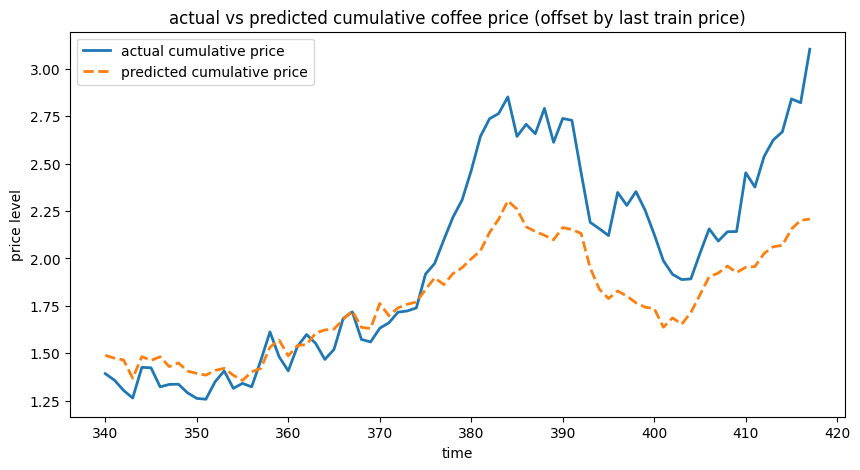

In [191]:
plt.figure(figsize=(10, 5))
plt.plot(test_idx, offset_cum_actual, label="actual cumulative price", linewidth=2)
plt.plot(test_idx, offset_cum_pred, label="predicted cumulative price", linestyle="--", linewidth=2)
plt.legend()
plt.xlabel("time")
plt.ylabel("price level")
plt.title("actual vs predicted cumulative coffee price (offset by last train price)")
plt.show()

